###  Example of the spectral PLV computation

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import time

import h5py
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from frites.conn.conn_spec import conn_spec
from tqdm import tqdm

#### Defining function to simulate de model

In [2]:
numba.jit(nopython=True)


def ar_model_dhamala(
    N=5000, Trials=10, Fs=200, C=0.2, t_start=0, t_stop=None, cov=None
):
    """
    AR model from Dhamala et. al.
    """

    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop == None:
            return t >= t_start
        else:
            return (t >= t_start) * (t <= t_stop)

    for i in tqdm(range(Trials)):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i, t] = (
                0.55 * X[i, t - 1]
                - 0.8 * X[i, t - 2]
                + interval(time[t], t_start, t_stop) * C * Y[i, t - 1]
                + E[t, 0]
            )
            Y[i, t] = 0.55 * Y[i, t - 1] - 0.8 * Y[i, t - 2] + E[t, 1]

    Z = np.zeros([Trials, 2, N])

    Z[:, 0, :] = X
    Z[:, 1, :] = Y

    return Z

Model parameters

In [3]:
N = 5000  # Number of observations
Fs = 200  # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C = 0.25  # Coupling parameter
Trials = 100  # Number of trials
freqs = np.arange(1, 100, 1)  # Frequency axis
# Covariance matrix
cov = np.array([[1.00, 0.00], [0.00, 1.00]])

Generating data

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials=Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.08it/s]


In [5]:
X = xr.DataArray(
    X,
    dims=("trials", "roi", "times"),
    coords=(np.arange(Trials), ["r0", "r1"], np.arange(N) / Fs),
)

### Measuring spectral phase-locking value

In [6]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs / 2.0

kw = dict(
    freqs=freqs,
    times="times",
    roi=None,
    foi=None,
    n_jobs=-1,
    mode="morlet",
    n_cycles=n_cycles,
    decim=15,
    metric="plv",
    sm_times=1.5,
    sm_freqs=1,
    block_size=1,
)

# compute the coherence
plv = conn_spec(X, **kw)

end = time.time()

print("Elapsed time to load super-tensor: " + str((end - start)) + " sec.")

WARNING | No regions of interest are provided (roi). Default ones are created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Phase-Locking Value (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.0s finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...99 : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 7.109002351760864 sec.


Text(0.5, 1.0, 'Spectral PLV')

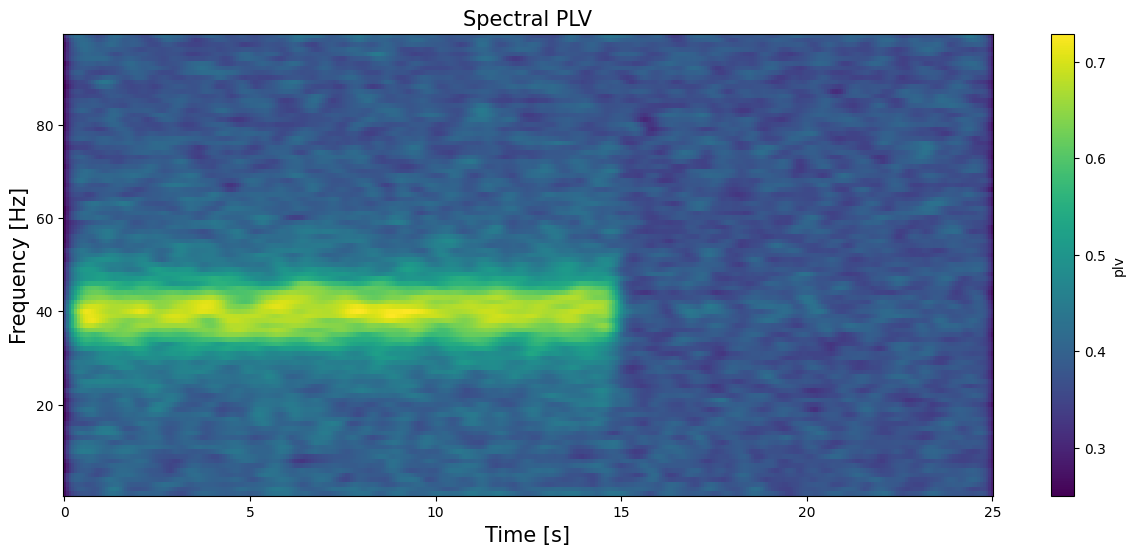

In [7]:
plt.figure(figsize=(15, 6))
plv.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs")
plt.ylabel("Frequency [Hz]", fontsize=15)
plt.xlabel("Time [s]", fontsize=15)
plt.title("Spectral PLV", fontsize=15)

### Single-trial spectral PLV

Here we average over bands of interest and plot the PLV at single-trial level.

In [8]:
kw["sm_times"] = 1.5
kw["foi"] = foi = np.array(
    [
        [0.1, 25.0],
        [25.0, 50.0],
        [50.0, 75.0],
        [75.0, 100.0],
    ]
)

plv = conn_spec(X, **kw)

WARNING | No regions of interest are provided (roi). Default ones are created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Phase-Locking Value (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...99 : 0/1 [00:00<?,       ?it/s]

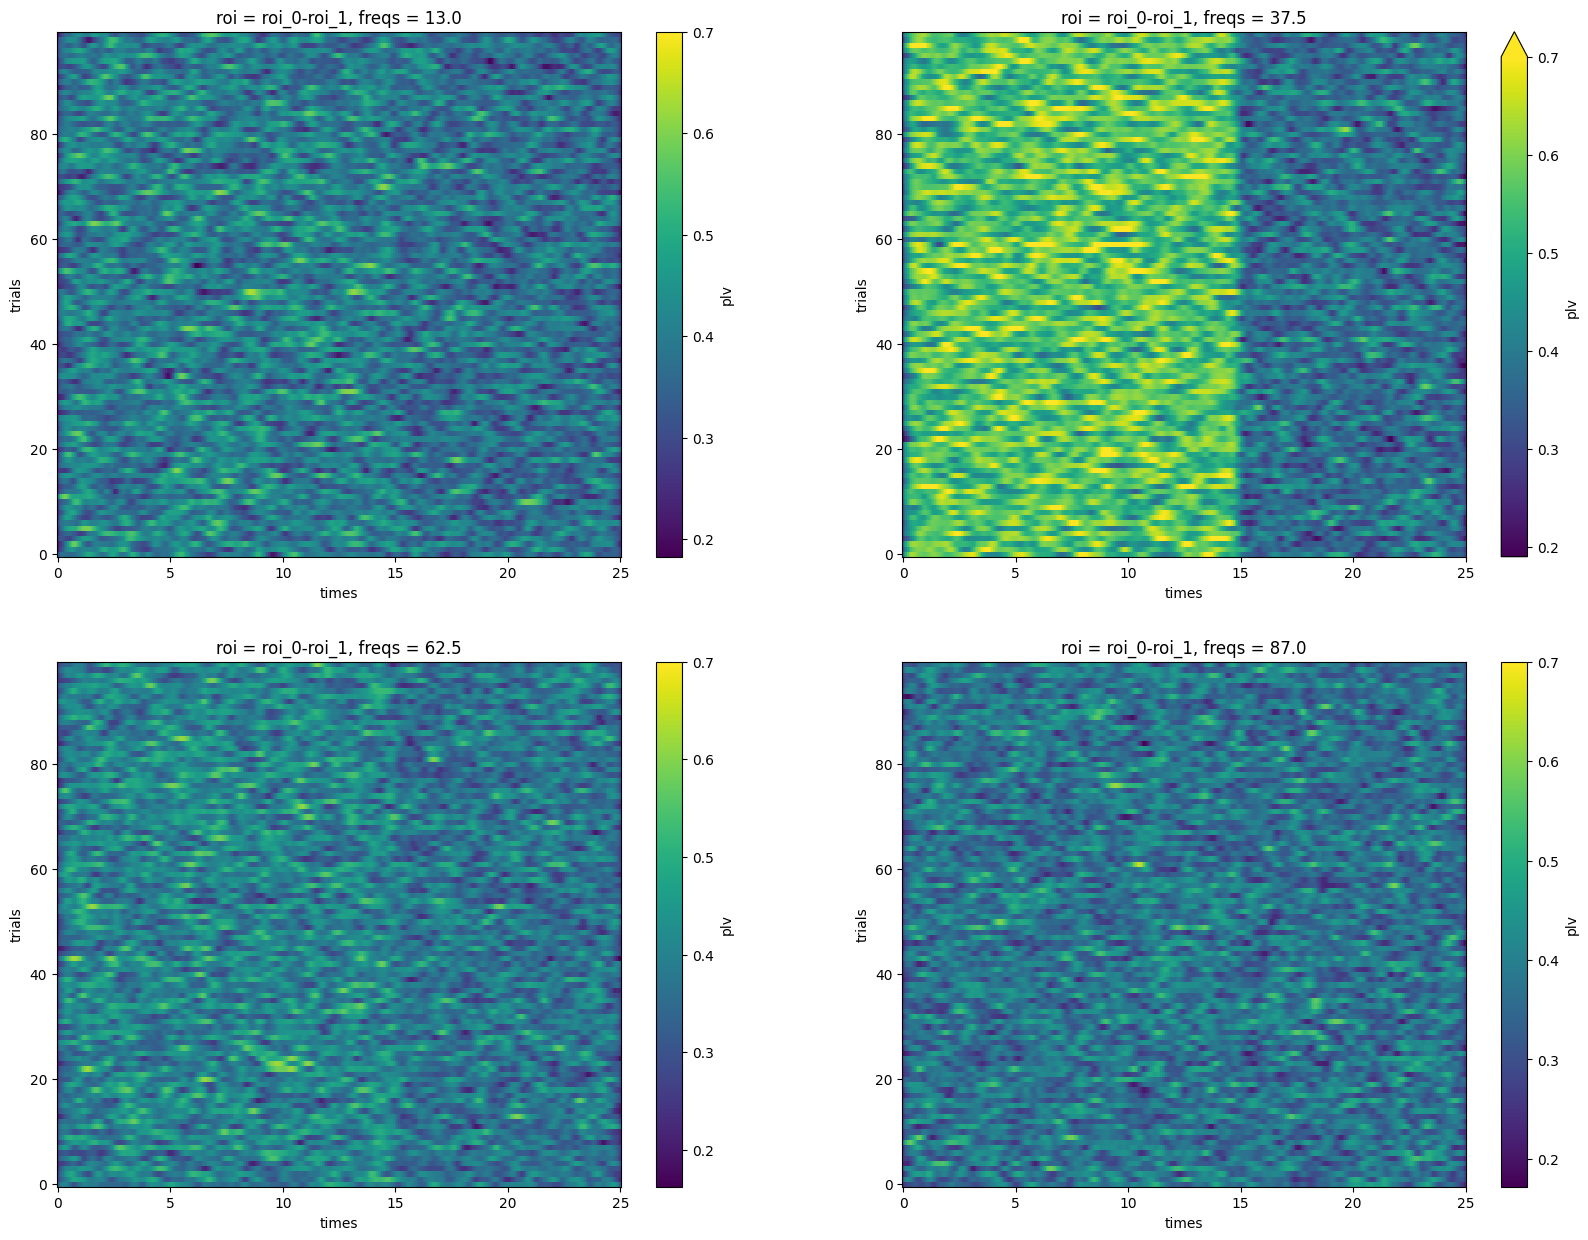

In [9]:
plt.figure(figsize=(20, 15))
for i in range(plv.sizes["freqs"]):
    plt.subplot(2, 2, i + 1)
    plv.isel(roi=0, freqs=i).plot.imshow(x="times", y="trials", vmax=0.7)
    # plt.title(bands[i])

### Surrogates

In [10]:
from GDa.signal.surrogates import phase_rand_surrogates, trial_swap_surrogates

In [11]:
kw["sm_times"] = 1.5
kw["foi"] = None

plv = conn_spec(X, **kw)

WARNING | No regions of interest are provided (roi). Default ones are created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Phase-Locking Value (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...99 : 0/1 [00:00<?,       ?it/s]

In [12]:
def _surrogate_plv(n_surr, val):

    seeds = np.arange(n_surr, dtype=int) * 100

    plv = []
    for seed in tqdm(seeds):
        X_rnd = phase_rand_surrogates(X, seed=seed, verbose=False)
        plv += [conn_spec(X_rnd, **kw)]
    return xr.concat(plv, "seeds")

In [13]:
plv_surr = _surrogate_plv(1, 1)

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No regions of interest are provided (roi). Default ones are created
Defining links (n_roi=2; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Phase-Locking Value (n_pairs=1, n_freqs=99, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    3.4s finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...99 : 0/1 [00:00<?,       ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Text(0.5, 1.0, 'Spectral PLV Surrogate')

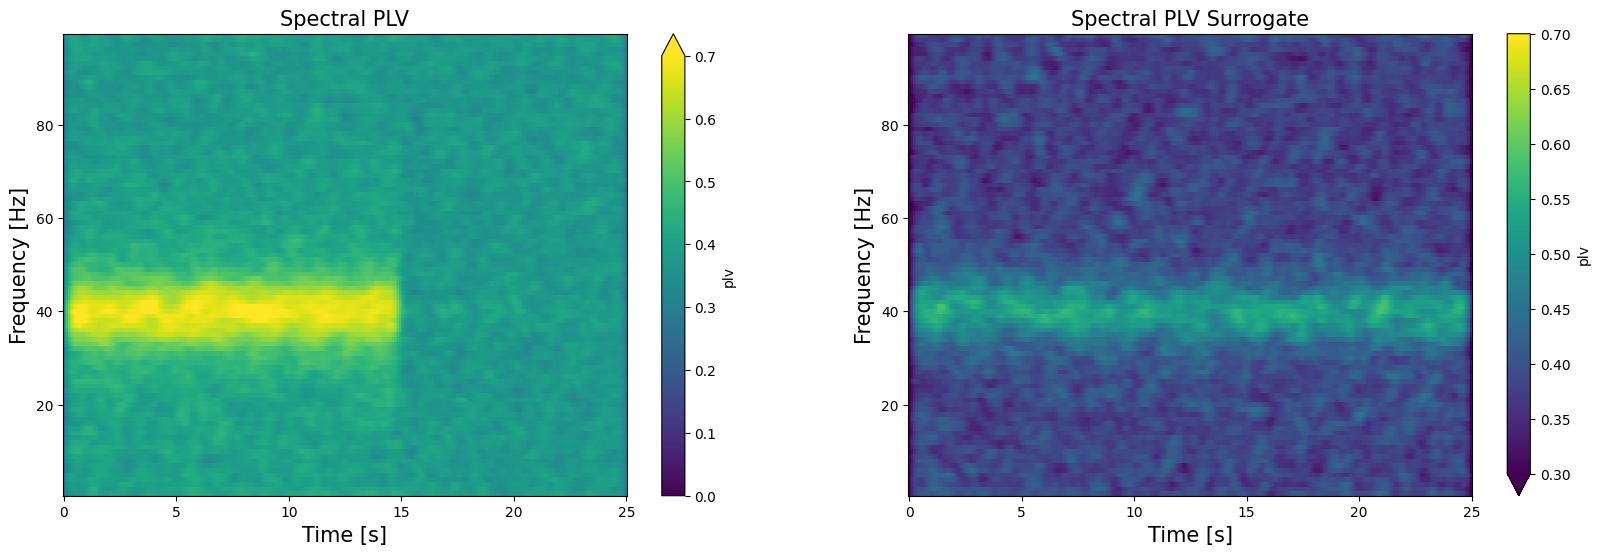

In [14]:
plt.figure(figsize=(20, 6))
# Original
plt.subplot(1, 2, 1)
plv.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmin=0.0, vmax=0.7)
plt.ylabel("Frequency [Hz]", fontsize=15)
plt.xlabel("Time [s]", fontsize=15)
plt.title("Spectral PLV", fontsize=15)
# Surrogate
plt.subplot(1, 2, 2)
plv_surr.isel(roi=0, seeds=0).mean(dim="trials").plot.imshow(
    x="times", y="freqs", vmin=0.3, vmax=0.7
)
plt.ylabel("Frequency [Hz]", fontsize=15)
plt.xlabel("Time [s]", fontsize=15)
plt.title("Spectral PLV Surrogate", fontsize=15)

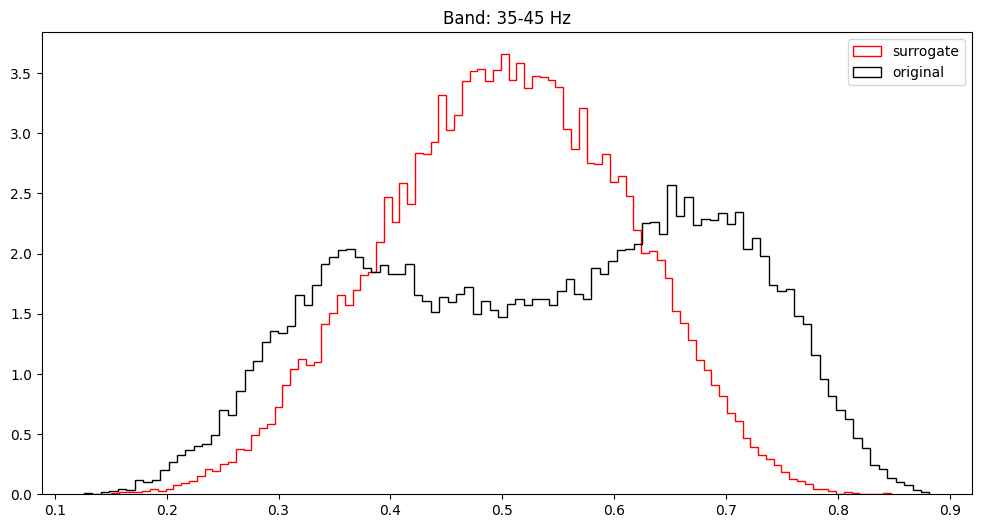

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(
    plv_surr.sel(freqs=slice(35, 45)).mean(dim="freqs").values.flatten(),
    100,
    fill=False,
    histtype="step",
    density=True,
    label="surrogate",
    color="r",
)
plt.hist(
    plv.sel(freqs=slice(35, 45)).mean(dim="freqs").values.flatten(),
    100,
    fill=False,
    histtype="step",
    density=True,
    label="original",
    color="k",
)
plt.title("Band: 35-45 Hz")
plt.legend()

In [16]:
plv_surr = plv_surr.isel(roi=0).quantile(0.95, dim=("seeds", "trials"))

In [17]:
plv_corr = np.clip(plv.isel(roi=0) - plv_surr, 0, np.inf)

Text(0.5, 1.0, 'Uncorrected PLV')

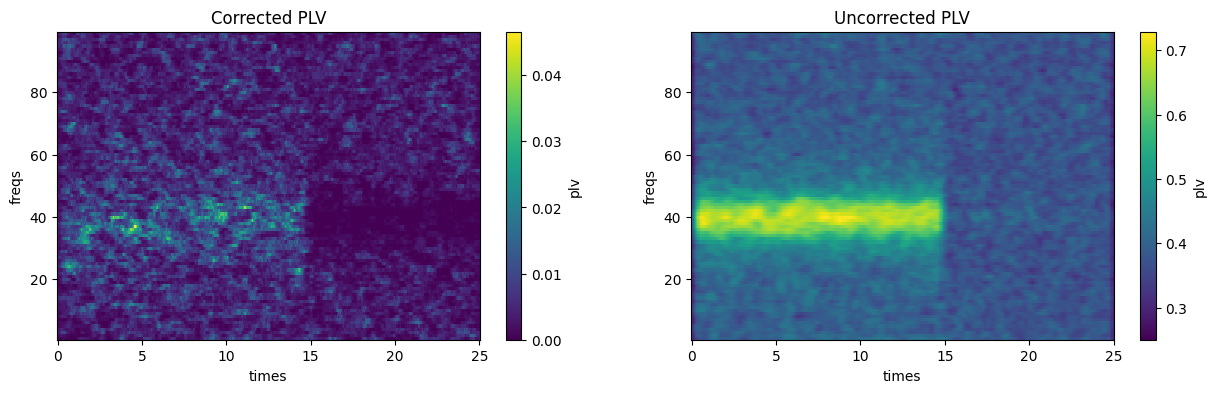

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plv_corr.mean("trials").plot.imshow()
plt.title("Corrected PLV")
plt.subplot(
    1,
    2,
    2,
)
plv.isel(roi=0).mean("trials").plot.imshow()
plt.title("Uncorrected PLV")

Text(0.5, 1.0, 'Uncorrected PLV')

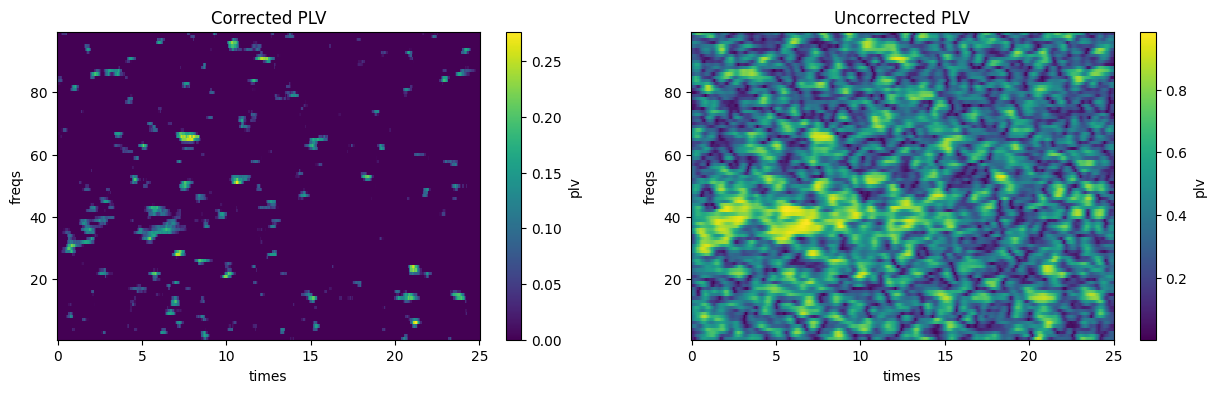

In [19]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plv_corr.isel(trials=10).plot.imshow()
plt.title("Corrected PLV")
plt.subplot(
    1,
    2,
    2,
)
plv.isel(trials=10).isel(roi=0).plot.imshow()
plt.title("Uncorrected PLV")